# Decision Trees

## In this project I will perform the following:
1. Implement two impurity measures: Gini and Entropy.
2. Construct a decision tree algorithm.
3. Prune the tree to achieve better results.
4. Visualize the results.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [80]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x9d6f9b0>, <__main__.Node at 0x9d6f970>]

## Data preprocessing

For the following exercise, I will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d


In [1]:

data = pd.read_csv('agaricus-lepiota.csv')

NameError: name 'pd' is not defined

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [82]:
data = data.dropna(axis='columns')

In [83]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [84]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.

In [85]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    label = data[:,-1]
    values, unique = np.unique(label, return_counts = True)  
    gini = 1 - (np.sum(np.square(unique / len(label))))
    return gini

In [86]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    label = data[:,-1]
    value, unique = np.unique(label, return_counts = True)  
    div = unique / len(label)
    log = np.log2(div)
    entropy = - np.dot(div, log)
    return entropy

In [87]:
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In my implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$


In [88]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    label = data[:, feature]
    values, unique = np.unique(label, return_counts = True)
    div = unique / len(label)
    results = []
    calc = []
    if(gain_ratio == False):
    #return Goodness of Split
        for x in range(len(values)):
            ratio_data = data[np.where(label == values[x]),:][0]
            results.append(impurity_func(ratio_data))
        prev = impurity_func(data)
        goodness = prev - np.dot(div, results)
    else:
        #return Gain Ratio
        tmp_goodness = goodness_of_split(data, feature, calc_entropy, gain_ratio = False)
        for y in range(len(values)):
            calc.append(div[y] * np.log2(div[y]))
            tmp_split = - np.sum(calc)
        goodness = tmp_goodness / tmp_split
    return goodness    
goodness = goodness_of_split(X_train, 0, calc_entropy, gain_ratio=True)
goodness

0.016696903686886817

## Building a Decision Tree

I Used a Python class to construct the decision tree with support the following functionality:

1. Initiating a node for a decision tree.
2. The code support both Gini and Entropy as impurity measures. 

In [89]:
class DecisionNode:
    
    def __init__(self, feature, value, parent=None, depth=0, max_depth=1000):
        self.feature = feature # column index of criteria being tested
        self.value = value
        self.parent = parent
        self.labels = []
        self.children = []
        self.depth = depth
        
        self.max_depth = max_depth
        
    def add_child(self, node):
        self.children.append(node)
    
    def find_best_feature(self, data, impurity_func):
        split_feature = 0
        max_gain_ratio = -float('inf')
        for i in range(0, data.shape[1]):
            tmp_gain = goodness_of_split(data, i, impurity_func, gain_ratio=True)
            if tmp_gain > max_gain_ratio:
                max_gain_ratio = tmp_gain
                split_feature = i

        return split_feature
    

    def partition_by_feature_labels(self, data, uniq_labels):
        partitioned_data = []
        for label in uniq_labels:
            feature_label_indices = np.where(data[:, self.feature] == label)[0]
            partitioned_data.append(np.array(data[feature_label_indices]))
        return partitioned_data

    def build(self, data, impurity_func, chi, gain_ratio):
        self.feature = self.find_best_feature(data[:, :-1], impurity_func)
        uniq_labels, count = np.unique(data[:, -1], return_counts=True)
        self.labels = dict(zip(uniq_labels, count))
        
        feature_labels = np.unique(data[:, self.feature])
        partitioned_data = self.partition_by_feature_labels(data, feature_labels)

        if chi != 1:
            num_of_features = len(feature_labels)-1
            if num_of_features == 0: return
            if chi_square(data, partitioned_data, self) < chi_table[num_of_features].get(chi):
                return

        impurity = impurity_func(data)
        if self.depth >= self.max_depth or impurity == 0:
            return
        
        new_depth = self.depth+1
        for node_label_idx in range(0, len(partitioned_data)):
            label_data = partitioned_data[node_label_idx]
            
            value = feature_labels[node_label_idx]
            new_node = DecisionNode(None, value, parent=self, depth=new_depth, max_depth=self.max_depth)
            self.add_child(new_node)
            new_node.build(label_data, impurity_func, chi, gain_ratio)

    def __str__(self):
        depth_spaces = ' ' * self.depth
        if not self.children:
            return f"{depth_spaces}[{self.parent.feature}={self.value}, leaf]: [{self.labels}]"
        else:
            feature_value = "ROOT" if self.depth == 0 else f"{self.parent.feature}={self.value}"
            return f"{depth_spaces}[{feature_value}, feature={self.feature}],"
        

In [90]:
def build_tree(data, impurity, gain_ratio=False, chi=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag

    Output: the root node of the tree.
    """
    root = None
    root = DecisionNode(None, None,max_depth=max_depth)
    root.build(data, impurity, chi, gain_ratio)
    return root

In [91]:
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation


In [92]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    hit = 0
    for inst in dataset:
        pred = predict(node, inst)
        if pred == inst[-1]:
            hit += 1
    
    accuracy = (hit / dataset.shape[0]) * 100
    return accuracy 

In [93]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    while len(node.children) > 0:
        f = False
        for brnch in node.children:
            if brnch.value == instance[node.feature]:
                f = True
                node = brnch
                break
        if not f: break

    pred = max(node.labels, key=node.labels.get)
    return pred

Calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree with the best test accuracy. 

In [94]:
#### Your code here ####
tree_names = ["tree_gini", "tree_entropy", "tree_entropy_gain_ratio"]
idx = 0
for tree_node in [tree_gini, tree_entropy, tree_entropy_gain_ratio]:
    tree_name = tree_names[idx]
    print(f"{tree_name} accuracy: for test={calc_accuracy(tree_node, X_test)}% for train={calc_accuracy(tree_node, X_train)}%")
    idx += 1

tree_gini accuracy: for test=81.58542589857213% for train=100.0%
tree_entropy accuracy: for test=81.58542589857213% for train=100.0%
tree_entropy_gain_ratio accuracy: for test=81.58542589857213% for train=100.0%


## Depth pruning

For the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] I will construct a tree and prune it according to the max_depth value. Next, I will calculate the training and testing accuracy.<br>
I will draw on a single plot the training and testing accuracy as a function of the max_depth and mark the best result on the graph with red circle.

In [95]:
depths = list(range(1, 11))
accuracy = {"test": [], "train": []}
for depth in depths:
    tree = build_tree(data=X_train, max_depth=depth, impurity=calc_entropy)
    accuracy["train"].append(calc_accuracy(tree, X_train))
    accuracy["test"].append(calc_accuracy(tree, X_test))
accuracy

{'test': [65.3865091088134,
  68.29148202855735,
  73.21516494337764,
  77.94190054160512,
  88.38010832102412,
  87.74002954209749,
  85.17971442639094,
  83.11176760216642,
  81.63466272772033,
  81.58542589857213],
 'train': [65.45215821434432,
  68.4556047923847,
  73.10027900869851,
  78.1716724109634,
  90.00492368291482,
  90.74347612013787,
  91.81027408501559,
  94.35417692433941,
  97.81716724109634,
  99.98358772361726]}

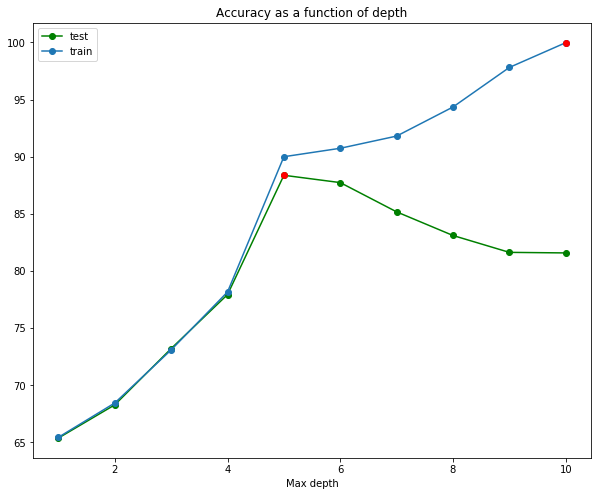

In [96]:
best_test_accuracy = np.argmax(accuracy["test"])
best_train_accuracy = np.argmax(accuracy["train"])

plt.title('Accuracy as a function of depth')
plt.xlabel('Max depth')


plt.plot(depths, accuracy["test"], "-o",  color="green", label="test")
plt.plot(depths, accuracy["train"], "-o", label="train")

plt.plot([best_test_accuracy+1], [accuracy["test"][best_test_accuracy]], color="red", marker="o", markersize=6)
plt.plot([best_train_accuracy+1], [accuracy["train"][best_train_accuracy]], color="red", marker="o", markersize=6)

plt.legend(["test", "train"])
plt.show()

## Chi square pre-pruning

For the following p-value cut-off values: [1 (no pruning), 0.5, 0.25, 0.1, 0.05, 0.0001 (max pruning)] I will construct a tree and prune it according to the cut-off value. Next, I will calculate the training and testing accuracy. <br>
I will draw on a single plot the training and testing accuracy as a function of the tuple (p-value, tree depth)and mark the best result on the graph with red circle.

In [97]:
### Chi square table values ###
# The first key is the degree of freedom 
# The second key is the p-value cut-off
# The values are the chi-statistic that you need to use in the pruning
chi_table = {1: {0.5 : 0.45,
                 0.25 : 1.32,
                 0.1 : 2.71,
                 0.05 : 3.84,
                 0.0001 : 100000},
             2: {0.5 : 1.39,
                 0.25 : 2.77,
                 0.1 : 4.60,
                 0.05 : 5.99,
                 0.0001 : 100000},
             3: {0.5 : 2.37,
                 0.25 : 4.11,
                 0.1 : 6.25,
                 0.05 : 7.82,
                 0.0001 : 100000},
             4: {0.5 : 3.36,
                 0.25 : 5.38,
                 0.1 : 7.78,
                 0.05 : 9.49,
                 0.0001 : 100000},
             5: {0.5 : 4.35,
                 0.25 : 6.63,
                 0.1 : 9.24,
                 0.05 : 11.07,
                 0.0001 : 100000},
             6: {0.5 : 5.35,
                 0.25 : 7.84,
                 0.1 : 10.64,
                 0.05 : 12.59,
                 0.0001 : 100000},
             7: {0.5 : 6.35,
                 0.25 : 9.04,
                 0.1 : 12.01,
                 0.05 : 14.07,
                 0.0001 : 100000},
             8: {0.5 : 7.34,
                 0.25 : 10.22,
                 0.1 : 13.36,
                 0.05 : 15.51,
                 0.0001 : 100000},
             9: {0.5 : 8.34,
                 0.25 : 11.39,
                 0.1 : 14.68,
                 0.05 : 16.92,
                 0.0001 : 100000},
             10: {0.5 : 9.34,
                  0.25 : 12.55,
                  0.1 : 15.99,
                  0.05 : 18.31,
                  0.0001 : 100000},
             11: {0.5 : 10.34,
                  0.25 : 13.7,
                  0.1 : 17.27,
                  0.05 : 19.68,
                  0.0001 : 100000}}

In [98]:
def chi_square(data, partitioned_data, node):
    instances_count = len(data)
    py0 = node.labels.get('e', 0) / instances_count
    py1 = node.labels.get('p', 0) / instances_count
    if np.product([py0, py1]) == 0: return 0
    
    chi = 0.0
    for part in partitioned_data:
        df = len(part)
        if df == 0: continue
        labels, counter = np.unique(part[:, -1], return_counts=True)
        pf = nf = 0.0
        for label in range(len(labels)):
            if labels[label] == 0.0: pf = counter[label]
            else: nf = counter[label]

        e0r = df * py0
        e1r = df * py1
        chi += ( ((pf - e0r) ** 2) / e0r ) + ( ((nf - e1r) ** 2) / e1r )

    return chi

def calc_depth(node):
    if len(node.children) == 0: return 0
    return 1 + np.max([calc_depth(child) for child in node.children])

In [99]:
accuracy = {"test": {}, "train": {}}
for p_value in chi_table[1].keys():
    tree = build_tree(data=X_train, chi=p_value, impurity=calc_entropy)
    depth = calc_depth(tree)
    accuracy["test"][str((p_value, depth))] = calc_accuracy(tree, X_test)
    accuracy["train"][str((p_value, depth))] = calc_accuracy(tree, X_train)
accuracy

{'test': {'(0.5, 11)': 82.52092565238799,
  '(0.25, 11)': 83.94879369768586,
  '(0.1, 10)': 85.86903003446578,
  '(0.05, 10)': 86.11521418020679,
  '(0.0001, 0)': 50.615460364352536},
 'train': {'(0.5, 11)': 98.8019038240604,
  '(0.25, 11)': 96.25800098473658,
  '(0.1, 10)': 91.4327917282127,
  '(0.05, 10)': 91.2850812407681,
  '(0.0001, 0)': 51.76431971114393}}

(0.05, 10)


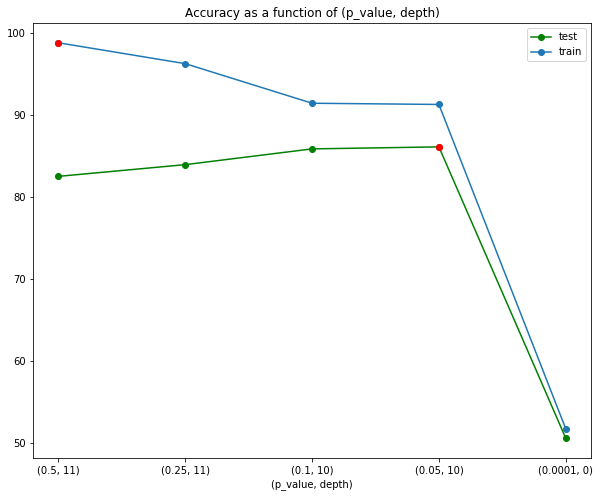

In [100]:
best_test_accuracy = max(accuracy["test"], key=accuracy["test"].get)
best_train_accuracy = max(accuracy["train"], key=accuracy["train"].get)

plt.title('Accuracy as a function of (p_value, depth)')
plt.xlabel('(p_value, depth)')


plt.plot(*zip(*accuracy["test"].items()), "-o",  color="green", label="test")
plt.plot(*zip(*accuracy["train"].items()), "-o",  label="train")

print(best_test_accuracy)
plt.plot([best_test_accuracy], [accuracy["test"][best_test_accuracy]], color="red", marker="o", markersize=6)
plt.plot([best_train_accuracy], [accuracy["train"][best_train_accuracy]], color="red", marker="o", markersize=6)

plt.legend(["test", "train"])
plt.show()

These are the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_chi - the best tree according to chi square pruning

In [101]:
best_depth = 5
best_chi_p_value = 0.05

tree_max_depth = build_tree(data=X_train, max_depth=best_depth, impurity=calc_entropy)
tree_chi = build_tree(data=X_train, chi=best_chi_p_value, impurity=calc_entropy)

print(f"tree_max_depth accuracy: {calc_accuracy(tree_max_depth, X_test)}")
print(f"tree_chi accuracy: {calc_accuracy(tree_chi, X_test)}")

tree_max_depth accuracy: 88.38010832102412
tree_chi accuracy: 86.11521418020679


## Number of Nodes

Of the two trees above I will choose the one with fewer nodes.

In [102]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """

    if len(node.children) == 0: return 1
    return 1 + np.sum([count_nodes(child) for child in node.children])

count_nodes(tree_entropy)

4130

## Print the tree 

I will pront the tree as the following in each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, I will print also the labels and their counts

```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
       [X5=a, leaf]: [{1.0: 5}]
       [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```

In [103]:
def print_pre(node, depth=0, max_depth_print=None):
    print(str(node))
    if not node.children or (max_depth_print and depth >= max_depth_print):
        return
    for child in node.children:
        print_pre(child, depth + 1, max_depth_print)

def print_tree(node, max_depth_print=0):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    print_pre(node, max_depth_print=max_depth_print)

In [104]:
print_tree(tree_entropy)

[ROOT, feature=20],
 [20=d, feature=0],
  [0=b, feature=1],
   [1=f, leaf]: [{'p': 4}]
   [1=s, leaf]: [{'p': 1}]
   [1=y, feature=2],
    [2=n, feature=7],
     [7=b, leaf]: [{'e': 1}]
     [7=n, leaf]: [{'p': 2}]
    [2=y, leaf]: [{'p': 1}]
  [0=f, feature=1],
   [1=f, feature=2],
    [2=e, feature=8],
     [8=n, feature=12],
      [12=g, feature=13],
       [13=g, leaf]: [{'e': 4}]
       [13=p, feature=18],
        [18=k, feature=19],
         [19=v, leaf]: [{'p': 1}]
         [19=y, leaf]: [{'e': 1}]
        [18=n, leaf]: [{'e': 1}]
       [13=w, leaf]: [{'e': 1}]
      [12=p, feature=13],
       [13=g, feature=19],
        [19=v, leaf]: [{'p': 1}]
        [19=y, leaf]: [{'e': 1}]
       [13=p, feature=18],
        [18=k, leaf]: [{'e': 1}]
        [18=n, feature=19],
         [19=v, leaf]: [{'e': 1}]
         [19=y, leaf]: [{'p': 1}]
       [13=w, leaf]: [{'e': 2}]
      [12=w, feature=13],
       [13=g, feature=18],
        [18=k, leaf]: [{'p': 1}]
        [18=n, leaf]: [{'e': 2}

       [13=w, feature=18],
        [18=k, feature=19],
         [19=v, leaf]: [{'p': 1}]
         [19=y, leaf]: [{'e': 1}]
        [18=n, leaf]: [{'e': 2}]
      [12=p, leaf]: [{'e': 8}]
      [12=w, leaf]: [{'e': 8}]
     [8=u, feature=12],
      [12=g, feature=13],
       [13=g, leaf]: [{'e': 3}]
       [13=p, leaf]: [{'e': 3}]
       [13=w, feature=18],
        [18=k, leaf]: [{'e': 2}]
        [18=n, leaf]: [{'p': 1}]
      [12=p, feature=13],
       [13=g, feature=18],
        [18=k, leaf]: [{'e': 2}]
        [18=n, leaf]: [{'p': 2}]
       [13=p, leaf]: [{'e': 3}]
       [13=w, leaf]: [{'e': 2}]
      [12=w, feature=13],
       [13=g, feature=18],
        [18=k, leaf]: [{'e': 2}]
        [18=n, feature=19],
         [19=v, leaf]: [{'e': 1}]
         [19=y, leaf]: [{'p': 1}]
       [13=p, leaf]: [{'e': 1}]
       [13=w, leaf]: [{'e': 4}]
     [8=w, feature=12],
      [12=g, feature=13],
       [13=g, feature=18],
        [18=k, feature=19],
         [19=v, leaf]: [{'p': 1}]
       

      [8=g, leaf]: [{'e': 2}]
      [8=k, leaf]: [{'e': 4}]
      [8=n, feature=18],
       [18=k, feature=19],
        [19=n, leaf]: [{'e': 1}]
        [19=s, leaf]: [{'p': 1}]
       [18=n, leaf]: [{'e': 2}]
      [8=w, leaf]: [{'e': 2}]
     [4=l, leaf]: [{'e': 9}]
     [4=n, leaf]: [{'p': 2}]
    [2=y, feature=4],
     [4=a, feature=8],
      [8=g, leaf]: [{'e': 4}]
      [8=k, leaf]: [{'e': 3}]
      [8=n, leaf]: [{'e': 4}]
      [8=w, feature=18],
       [18=k, feature=19],
        [19=n, leaf]: [{'e': 1}]
        [19=s, leaf]: [{'p': 1}]
       [18=n, leaf]: [{'e': 2}]
     [4=l, feature=8],
      [8=g, leaf]: [{'e': 4}]
      [8=k, feature=18],
       [18=k, leaf]: [{'e': 2}]
       [18=n, feature=19],
        [19=n, leaf]: [{'p': 1}]
        [19=s, leaf]: [{'e': 1}]
      [8=n, feature=18],
       [18=k, feature=19],
        [19=n, leaf]: [{'p': 1}]
        [19=s, leaf]: [{'e': 1}]
       [18=n, leaf]: [{'e': 2}]
      [8=w, leaf]: [{'e': 3}]
  [0=f, feature=1],
   [1=f, featu

  [0=f, feature=1],
   [1=f, leaf]: [{'e': 5}]
   [1=g, leaf]: [{'p': 1}]
   [1=s, feature=2],
    [2=e, feature=4],
     [4=f, feature=10],
      [10=k, feature=11],
       [11=k, leaf]: [{'p': 4}]
       [11=s, feature=12],
        [12=p, leaf]: [{'p': 1}]
        [12=w, feature=13],
         [13=p, leaf]: [{'p': 1}]
         [13=w, leaf]: [{'e': 1}]
      [10=s, leaf]: [{'p': 7}]
     [4=s, feature=10],
      [10=k, feature=11],
       [11=k, leaf]: [{'p': 1}]
       [11=s, feature=12],
        [12=p, leaf]: [{'e': 1}]
        [12=w, leaf]: [{'p': 1}]
      [10=s, feature=11],
       [11=k, leaf]: [{'p': 2}]
       [11=s, feature=12],
        [12=p, feature=13],
         [13=p, leaf]: [{'p': 1}]
         [13=w, leaf]: [{'e': 1}]
        [12=w, leaf]: [{'p': 1}]
     [4=y, feature=10],
      [10=k, leaf]: [{'p': 4}]
      [10=s, feature=11],
       [11=k, leaf]: [{'p': 3}]
       [11=s, feature=12],
        [12=p, leaf]: [{'p': 1}]
        [12=w, leaf]: [{'e': 1}]
    [2=n, feature=4

        [11=k, leaf]: [{'p': 4}]
        [11=s, feature=12],
         [12=p, feature=13],
          [13=p, leaf]: [{'p': 1}]
          [13=w, leaf]: [{'e': 1}]
         [12=w, leaf]: [{'p': 2}]
      [4=y, feature=10],
       [10=k, feature=11],
        [11=k, feature=12],
         [12=p, leaf]: [{'e': 1}]
         [12=w, leaf]: [{'p': 1}]
        [11=s, leaf]: [{'p': 4}]
       [10=s, feature=11],
        [11=k, feature=12],
         [12=p, feature=13],
          [13=p, leaf]: [{'p': 1}]
          [13=w, leaf]: [{'e': 1}]
         [12=w, leaf]: [{'p': 2}]
        [11=s, feature=12],
         [12=p, leaf]: [{'p': 2}]
         [12=w, leaf]: [{'e': 1}]
     [3=t, leaf]: [{'e': 1}]
    [2=p, leaf]: [{'e': 2}]
   [1=y, feature=2],
    [2=c, leaf]: [{'e': 2}]
    [2=e, feature=4],
     [4=f, leaf]: [{'p': 9}]
     [4=s, feature=10],
      [10=k, feature=11],
       [11=k, leaf]: [{'p': 2}]
       [11=s, feature=12],
        [12=p, feature=13],
         [13=p, leaf]: [{'p': 1}]
         [13=